# Segmenting and Clustering Neighborhoods in Toronto

This notebook presents the assignment for week 3 of the Applied Data Science Capstone class, from IBM + COursera.

Author: Joana Smith

# Part 1 - Scrape the web and generate a Panda Dataframe

Scrape the Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:

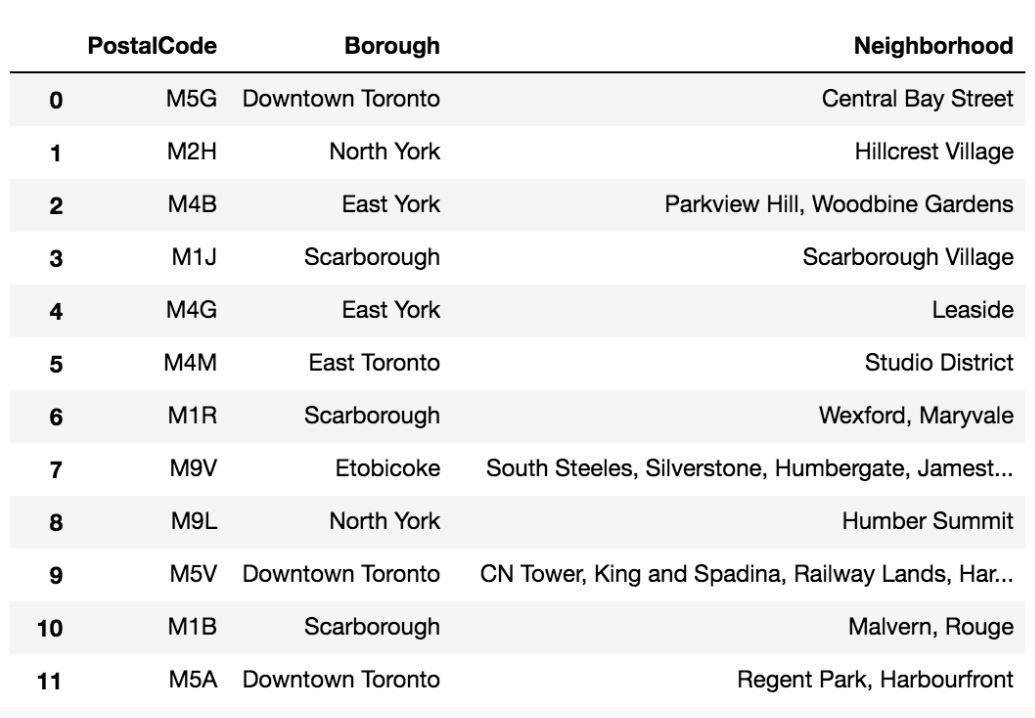

In [1]:
from IPython.display import Image
Image(filename =  "TableNeighborhood_Ex.jpg", width=500, height=500)

### i) Open the wikipedia page (html) and turn that into a soup object

In [2]:
import requests
import wget
import urllib
from bs4 import BeautifulSoup

Open the website & creat at new object soup based on the website

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(wiki_html)

### ii) Scrape the soup and get the data we need: Postcode, Borough and Neighborhood

We could use the command >>>  print(soup.prettify()) <<< in order to print the html code, analyse it and understand where the data we want is.
In order to make this notebook cleaner, I will use the developer tool at the browser to help me understand where the table we need is.
This is what we see by using the developer tool:

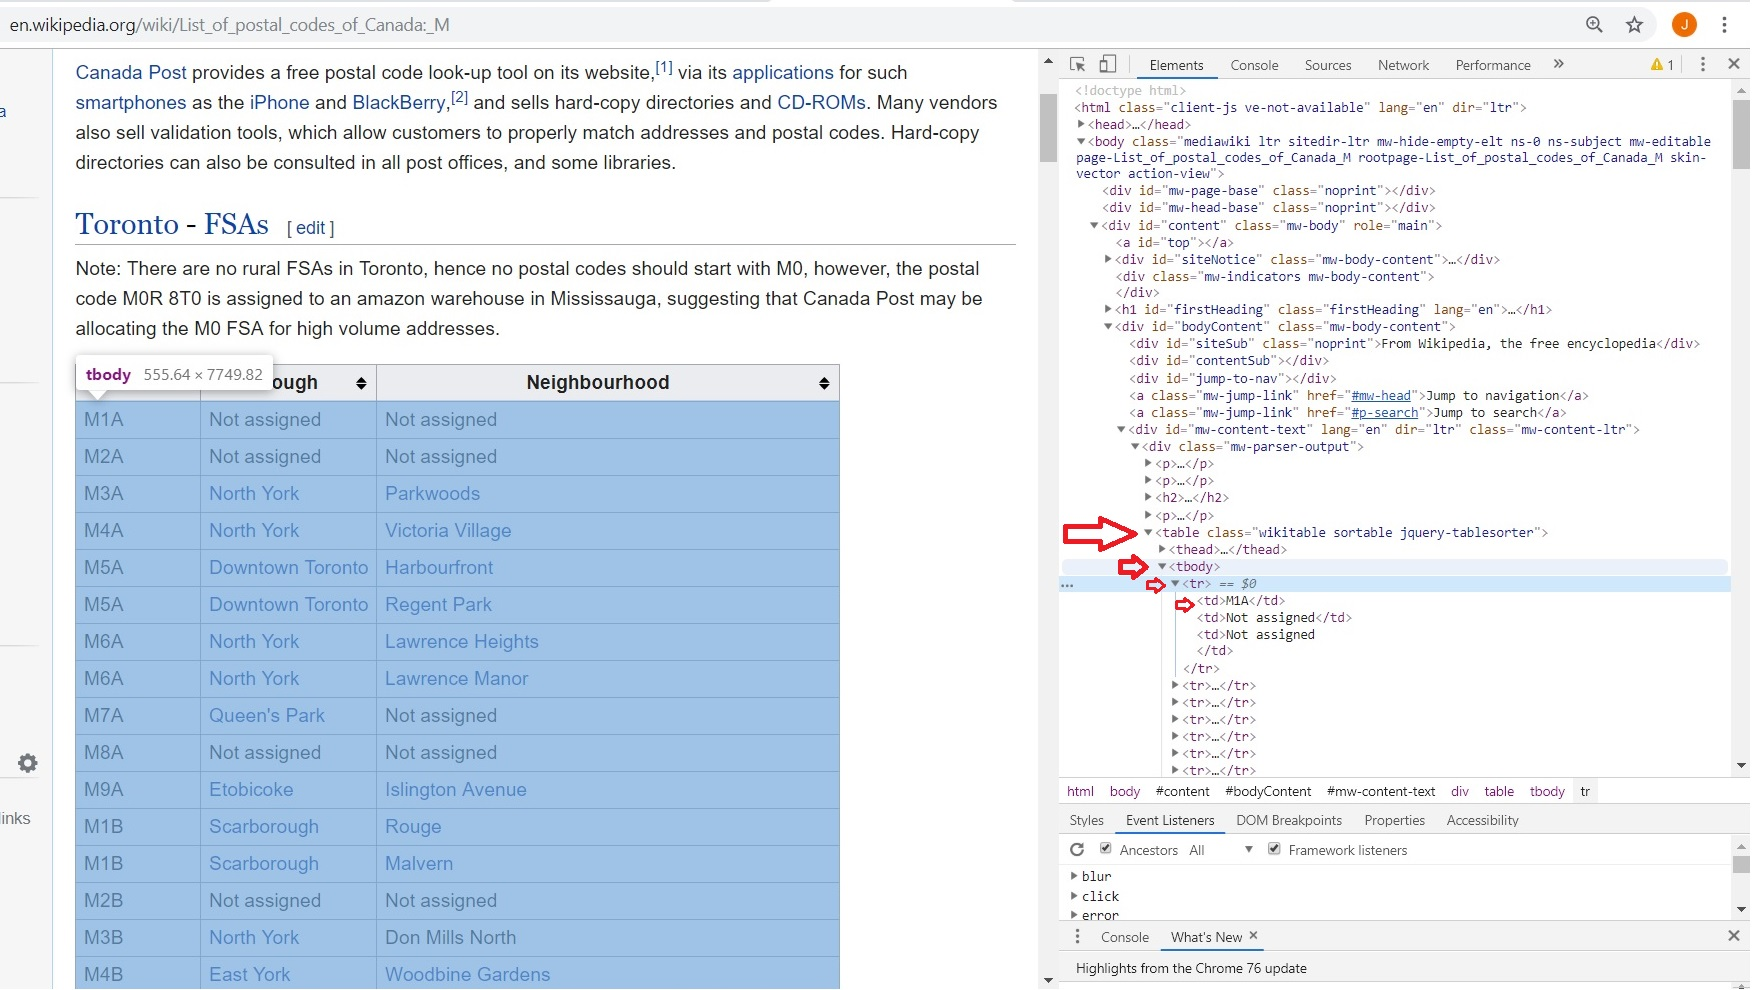

In [4]:
Image(filename =  "Wikipedia.jpg", width=1200, height=1200)

We can see that the date we need is found at a structure like this:

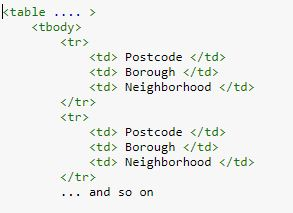

In [5]:
Image(filename =  "StructureHTML.jpg", width=350, height=350)

So the first thing is to find the table in our html

In [6]:
table=soup.find('table')

Now we only have the table data. But we only want the following info: Postcode, Borough and Neighborhood.

* All our data is inside the "body"
* Each area description is between a "tr" and a "\tr"
    * Inside that, the data for Postcode, Borough and Neighborhood are each one of them in between "td"s    
    
So let's do a small loop to gather the info for the first 3 neighborhoods to get a better understanding of our data.

In [7]:
i=0
for neighborhood in table.tbody.find_all('tr'):     # We will check each tr
    if i<4:
        for info in neighborhood.find_all('td'):    # Inside each tr we will check each td
            print(info.text)
        i=i+1

M1A
Not assigned
Not assigned

M2A
Not assigned
Not assigned

M3A
North York
Parkwoods



Great! It works!
So now instead of printing, Let's create a panda dataset to receive the postcode, borough and neighborhood name for each postcode.

### iii) Transforming the data into a Panda Dataframe

In [8]:
import pandas as pd

# define the dataframe columns
column_names = ['Postcode','Borough', 'Neighborhood'] 

# instantiate the dataframe
df = pd.DataFrame(columns=column_names)

i=0
for neighborhood in table.tbody.find_all('tr'):
    temp=[]
    for info in neighborhood.find_all('td'):
        temp.append(info.text.replace('\n',''))
    
    if temp!=[]: #skip in case there are no "td"
        # If no borough is assigned, we will skip that PostCode
        if temp[1]!='Not assigned':
            # If no neighborhood is assigned, then we should assing the Borough name to the neighborhood name
            if temp[2]=='Not assigned':
                df=df.append({'Postcode':temp[0],'Borough':temp[1],'Neighborhood':temp[1]}, ignore_index=True)
            #Check if the borough is already listed in the dataframe
            elif temp[0] in df['Postcode'].values:
                old=df.loc[df['Postcode'] == temp[0], 'Neighborhood']
                new=old+', '+temp[2]
                df.loc[df['Postcode'] == temp[0], 'Neighborhood']=new
            else:
                df=df.append({'Postcode':temp[0],'Borough':temp[1],'Neighborhood':temp[2]}, ignore_index=True)




Let's show the first 15 rows of this dataframe:

In [9]:
df.head(15)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


And also the shape of our dataframe:

In [10]:
df.shape

(103, 3)

Our dataframe has 103 rows and 3 columns.

### --- End of part 1: Panda dataframe generated from data from wikipedia. ---

Now let's go to part 2! :)

#  Part 2 - Generate a dataframe that contains latitute and longitude for each Borough

### i) First attempt: Getting latitude and longitude using Geocoder

In [11]:
import geocoder

The geocoder was not consistent, returning a lot of "None" answers. The code below shows the results obtained from the Geocoder for the 1st 10 attempts just an illustration.

In [12]:
#Looping through the postal codes
for postal_code in df['Postcode']:

    #initialize variables to None
    lat_lng_coords=None
    
    i=1
    #loop until you get the coordinates
    while(lat_lng_coords is None):
        if i < 11:
            g=geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            print('attempt:',i)
            lat_lng_coords=g.latlng
            print(lat_lng_coords)
            i=i+1
        else: break
    df.loc[df['Postcode'] == postal_code, 'Latitude']=lat_lng_coords[0]
    df.loc[df['Postcode'] == postal_code, 'Longitude']=lat_lng_coords[1]

attempt: 1
None
attempt: 2
None
attempt: 3
None
attempt: 4
None
attempt: 5
None
attempt: 6
None
attempt: 7
None
attempt: 8
None
attempt: 9
None
attempt: 10
None


TypeError: 'NoneType' object is not subscriptable

### ii) Using csv file provided

As the geocoder didn't result in success, let's use the csv file provided to get the lat and lng information.

Let`s first download the file:

In [13]:
import wget
url='https://cocl.us/Geospatial_data'
lat_lng_set = wget.download(url)
print('Data downloaded!')

100% [................................................................................] 2891 / 2891Data downloaded!


And then we will read the csv file as a Panda Dataframe and show the first 5 rows if the dataframe:

In [14]:
geo_df = pd.read_csv(lat_lng_set)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now it's time to merge this datafrae with the ones with the names of Boroughs and Neighborhoods. We will join them using the Postcode reference.

In [15]:
# Merge dataframes
df = df.join(geo_df.set_index('Postal Code'), on='Postcode')

### And that's ready: Let's see the first lines of our new dataframe:

In [16]:
df.head(12)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### --- End of part 2: Dataframe with columns Postcode, Borough, Neighborhood, Latitude and Longitude. ---

Now let's go to part 3! :)

# Part 3 - Exploring and Clustering the Neighborhoods of Toronto

Let's first import all the libraries needed for this section.

In [17]:
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

### i) Create a dataframe with only boroughs that contain the word Toronto

In [18]:
df_toronto= df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


### ii) Let's take a quick look at the neighborhoods of Toronto in a map:

In [19]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### iii) Getting venues information from Foursquare

Setting client_id, client_secret and version for the conection with the Foursquare API

In [20]:
# @hidden_cell
# Define Foursquare Credentials and Version


CLIENT_ID = 'PU2M2NDZNNYIYMAIGGABUUSUJOI0RC2X0X1YGVAGTG5B514S' # your Foursquare ID
CLIENT_SECRET = '2KRDYEHZW4JS5HKY3XQXE54FQUYLRJU5BYMZXG2RC3VAI5ZP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create functions to extract the category of the venue & to repeat this process for each neighborhood

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


# Let's create a function to repeat the same process to all the neighborhoods in toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's call the function defined above to get the top 100 venues inside a radius of 500m of the center of each neighborhood

In [22]:
# Call the function
LIMIT=100

toronto_venues_pre = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )


Let's check the shape of the resulting dataframe and check the first rows of it

In [23]:
# Let's check the size of the resulting dataframe
print('shape: ',toronto_venues_pre.shape)
toronto_venues_pre.head()

shape:  (1705, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [24]:
#Let's check how many venues were returned for each neighborhood
toronto_venues_pre.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",20,20,20,20,20,20
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",49,49,49,49,49,49
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


We can see that for some neighborhoods we got a really small amount of venues. For example, Roselawn only has 1 venue listed, and The Beaches only 5.

Really small numbers of venues don't give us enough information to understand the characteristics of each neighborhoods in order to analyse their similarities with the other neighborhoods when clustering them.

So let's drop the neighborhoods with 10 or less venues listed.

step1: create a list of neighborhoods with 10 or less venues:

In [25]:
min_venues=10
temp_group=toronto_venues_pre.groupby('Neighborhood').count()
temp_group=temp_group[temp_group['Venue']<=min_venues]
toExclude=temp_group.index.values

step2: exclude those neighborhoods from the dataframe toronto_venues

In [26]:
toronto_venues=toronto_venues_pre[~toronto_venues_pre['Neighborhood'].isin(toExclude)].reset_index(drop=True)
#Let's check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",20,20,20,20,20,20
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",49,49,49,49,49,49
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


Now we can see that we only have neighborhoods with more than 20 venues.

Let's see the shape of our dataframe:

In [27]:
toronto_venues.shape

(1677, 7)

So let's see how many unique categories we have:

In [28]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories.


One hot encoding: Let's create a new dataframe toronto_onehot in wich we will use the get_dummies and transform each venue category into a column with 1 (true) or zero (false)

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']],prefix='')
# putting the neighborhood column back
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
#toronto_onehot.columns = toronto_onehot.columns.str.replace("_", "")
toronto_onehot.head()

,Neighborhood,_Afghan Restaurant,_Airport,_Airport Food Court,_Airport Gate,_Airport Lounge,_Airport Service,_Airport Terminal,_American Restaurant,_Antique Shop,...,_Thrift / Vintage Store,_Toy / Game Store,_Trail,_Train Station,_Vegetarian / Vegan Restaurant,_Video Game Store,_Vietnamese Restaurant,_Wine Bar,_Wings Joint,_Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's check the shape of the new dataframe

In [30]:
# And let's examine the new dataframe size.
toronto_onehot.shape

(1677, 232)

And then let's group rows by neighborhood and take the mean of the frequency of each category.

Let's see the shape and the first lines.

In [31]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('shape: ',toronto_grouped.shape)
toronto_grouped.head()

shape:  (31, 232)


,Neighborhood,_Afghan Restaurant,_Airport,_Airport Food Court,_Airport Gate,_Airport Lounge,_Airport Service,_Airport Terminal,_American Restaurant,_Antique Shop,...,_Thrift / Vintage Store,_Toy / Game Store,_Trail,_Train Station,_Vegetarian / Vegan Restaurant,_Video Game Store,_Vietnamese Restaurant,_Wine Bar,_Wings Joint,_Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.0,0.000000
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.00,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000


Let's put that into a panda dataframe.

But first, let's write a function to sort the venues in descending order.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
    # meu comentario: numpy.arange returns evenly spaced values within the interval 0 (as nothing diff was declared) and the num_top_venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",_Coffee Shop,_Café,_Bar,_Steakhouse,_American Restaurant,_Asian Restaurant,_Burger Joint,_Thai Restaurant,_Hotel,_Breakfast Spot
1,Berczy Park,_Coffee Shop,_Cocktail Bar,_Cheese Shop,_Bakery,_Steakhouse,_Italian Restaurant,_Seafood Restaurant,_Farmers Market,_Café,_Beer Bar
2,"Brockton, Exhibition Place, Parkdale Village",_Coffee Shop,_Café,_Breakfast Spot,_Gym,_Furniture / Home Store,_Pet Store,_Climbing Gym,_Restaurant,_Caribbean Restaurant,_Burrito Place
3,Business Reply Mail Processing Centre 969 Eastern,_Light Rail Station,_Yoga Studio,_Auto Workshop,_Pizza Place,_Recording Studio,_Restaurant,_Butcher,_Burrito Place,_Brewery,_Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",_Airport Service,_Airport Lounge,_Airport Terminal,_Harbor / Marina,_Bar,_Plane,_Coffee Shop,_Sculpture Garden,_Boat or Ferry,_Boutique


Now we have an organized dataframe with information from the top 100 venues in each neighborhood in Toronto.

It's time to cluster the neighborhoods based in this information!!!


### iv) Clustering neighborhoods

We are clustering the neighborhoods in 5 different clusters.

In [34]:
# Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 2, 0, 0, 0, 3, 0])

In [35]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto 

# merge toronto_grouped with df_toronto to add latitude/longitude for each neighborhood

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# As we are only looking at the neighborhoods with more than 10 venues, we should drop the neighborhoods of Toronto with 10 or less venues.
toronto_merged.dropna(inplace=True)
# Making sure the columns with cluster number has type integer
toronto_merged[["Cluster Labels"]] = toronto_merged[["Cluster Labels"]].astype("int64")
toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,_Coffee Shop,_Park,_Bakery,_Pub,_Café,_Theater,_Gym / Fitness Center,_Mexican Restaurant,_Breakfast Spot,_Farmers Market
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,_Coffee Shop,_Clothing Store,_Cosmetics Shop,_Middle Eastern Restaurant,_Café,_Ice Cream Shop,_Bookstore,_Ramen Restaurant,_Restaurant,_Lingerie Store
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,_Coffee Shop,_Restaurant,_Hotel,_Café,_Italian Restaurant,_Gastropub,_Breakfast Spot,_Cosmetics Shop,_Beer Bar,_Cocktail Bar
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,_Coffee Shop,_Cocktail Bar,_Cheese Shop,_Bakery,_Steakhouse,_Italian Restaurant,_Seafood Restaurant,_Farmers Market,_Café,_Beer Bar
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,_Coffee Shop,_Café,_Ice Cream Shop,_Italian Restaurant,_Sandwich Place,_Burger Joint,_Chinese Restaurant,_Bar,_Salad Place,_Bubble Tea Shop


In [36]:
# Finally, let's visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see at the map above, even after taking out of the neighborhoods with 10 or less venues, most of our neighborhoods were classified in the same cluster 0 (red), with the other clusters having only one neighborhood each.

Let's take a look at the most common venues of each cluster to understand better each location.

#### Cluster 1:

In [37]:
#Cluster 1¶
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",0,_Coffee Shop,_Park,_Bakery,_Pub,_Café,_Theater,_Gym / Fitness Center,_Mexican Restaurant,_Breakfast Spot,_Farmers Market
1,"Ryerson, Garden District",0,_Coffee Shop,_Clothing Store,_Cosmetics Shop,_Middle Eastern Restaurant,_Café,_Ice Cream Shop,_Bookstore,_Ramen Restaurant,_Restaurant,_Lingerie Store
2,St. James Town,0,_Coffee Shop,_Restaurant,_Hotel,_Café,_Italian Restaurant,_Gastropub,_Breakfast Spot,_Cosmetics Shop,_Beer Bar,_Cocktail Bar
4,Berczy Park,0,_Coffee Shop,_Cocktail Bar,_Cheese Shop,_Bakery,_Steakhouse,_Italian Restaurant,_Seafood Restaurant,_Farmers Market,_Café,_Beer Bar
5,Central Bay Street,0,_Coffee Shop,_Café,_Ice Cream Shop,_Italian Restaurant,_Sandwich Place,_Burger Joint,_Chinese Restaurant,_Bar,_Salad Place,_Bubble Tea Shop
7,"Adelaide, King, Richmond",0,_Coffee Shop,_Café,_Bar,_Steakhouse,_American Restaurant,_Asian Restaurant,_Burger Joint,_Thai Restaurant,_Hotel,_Breakfast Spot
8,"Dovercourt Village, Dufferin",0,_Pharmacy,_Bakery,_Supermarket,_Park,_Music Venue,_Café,_Middle Eastern Restaurant,_Brewery,_Bar,_Bank
9,"Harbourfront East, Toronto Islands, Union Station",0,_Coffee Shop,_Hotel,_Aquarium,_Italian Restaurant,_Café,_Fried Chicken Joint,_Brewery,_Bakery,_Scenic Lookout,_Pizza Place
10,"Little Portugal, Trinity",0,_Bar,_Coffee Shop,_Asian Restaurant,_Boutique,_Restaurant,_French Restaurant,_Bakery,_Pizza Place,_Cocktail Bar,_Men's Store
11,"The Danforth West, Riverdale",0,_Greek Restaurant,_Coffee Shop,_Italian Restaurant,_Furniture / Home Store,_Ice Cream Shop,_Pub,_Bookstore,_Brewery,_Bubble Tea Shop,_Burger Joint


#### Cluster 1:

In [38]:
#Cluster 2¶
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,"Parkdale, Roncesvalles",1,_Breakfast Spot,_Gift Shop,_Restaurant,_Bank,_Dog Run,_Movie Theater,_Italian Restaurant,_Eastern European Restaurant,_Dessert Shop,_Bar


#### Cluster 2:

In [39]:
#Cluster 3¶
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,"CN Tower, Bathurst Quay, Island airport, Harbo...",2,_Airport Service,_Airport Lounge,_Airport Terminal,_Harbor / Marina,_Bar,_Plane,_Coffee Shop,_Sculpture Garden,_Boat or Ferry,_Boutique


#### Cluster 3:

In [40]:
#Cluster 4¶
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Christie,3,_Café,_Grocery Store,_Park,_Convenience Store,_Nightclub,_Diner,_Baby Store,_Restaurant,_Italian Restaurant,_Coffee Shop


#### Cluster 4:

In [41]:
#Cluster 5¶
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",4,_Pub,_Coffee Shop,_Pizza Place,_Light Rail Station,_Sports Bar,_Restaurant,_Supermarket,_Sushi Restaurant,_Bagel Shop,_Fried Chicken Joint


Conclusions:

We can conclude the Toronto has a lot of cafes, coffe shops and restaurants, which are the most frequent venues in our biggest cluster: the zero, as described below:

Cluster 0: Cafes, coffe shops and restaurants are the more frequent spots

While the other areas have a more diverse scene
Cluster 1: Besides food spots, the area has some other conveniences like bank, theater amd gift shops
Cluster 2: Airport area, with the most frequent venues being the ones inside the airport
Cluster 3: Together with cafes, grocerie stores and parks are among the most common venues
Cluster 4: Together with coffe shops, pubs, sports bar and light rail stations are among the most common venues.